# Forecasting customer churn for a telecom company

# Цель

**Построить модель пердсказывающую вероятность ухода клиента и максимизировать метрику ROC-AUC**

# Задачи

- Исследовательский анализ данных / предобработка
    - Изучение данных
    - Предобработка
    - Создание новых признаков
    - Исследовательский анализ данных / визуализация
    - Вывод по EDA
- Обучение модели
    - Кодирование категориальных признаков
    - Подготовка обучающей и тестовой выборок
    - Масштабирование
    - RandomForestClassifier
    - LGBMClassifier
    - CatBoostClassifier
    - Подготовка таблицы с результатами
- Отчет

### Описание проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020.

- `contract.csv`:
    - `customerID` - уникальный ID клиента
    - `BeginDate` - дата заключения договора
    - `EndDate` - дата расторжения договора
    - `Type` - тип оплаты за услуги (ежемесячный платёж или раз в год, несколько лет)
    - `PaperlessBilling` - безналичный расчет
    - `PaymentMethod` - способ оплаты 
    - `MonthlyCharges` - ежемесячные траты за услуги 
    - `TotalCharges` - общая сумма трат за услуги
    
- `personal.csv`:

    - `customerID` - уникальный ID клиента
    - `gender` - пол клиента
    - `Partner` - наличие супруга(и)
    - `Dependents` - наличие иждивенцев
    
- `internet.csv`:

    - `customerID` - уникальный ID клиента
    - `InternetService` - варианты подключения интернет-соединения
    - `OnlineSecurity` - услуга блокировки небезопасных сайтов
    - `OnlineBackup` - услуга Облачного хранилища файлов
    - `DeviceProtection` - наличие услуги антивируса
    - `TechSupport`- услуга выделенной линии технической поддержки
    - `StreamingTV` - услуга стримингового телевидения
    - `StreamingMovies` - услуга каталога фильмов
    
- `phone.csv`:

    - `customerID` - уникальный ID клиента
    - `MultipleLines` - возможность ведения параллельных линий во время звонка


## Импорт библиотек

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [ ]:
pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
import math

# from scipy import stats as st

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


from lightgbm import LGBMClassifier

import phik
from phik.report import plot_correlation_matrix
from phik import report

## Загрузка данных 

In [ ]:
try:
  contract = pd.read_csv('/datasets/final_provider/contract.csv')

  personal = pd.read_csv('/datasets/final_provider/personal.csv')

  internet = pd.read_csv('/datasets/final_provider/internet.csv')

  phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
  contract = pd.read_csv('/content/contract.csv')

  personal = pd.read_csv('/content/personal.csv')

  internet = pd.read_csv('/content/internet.csv')

  phone = pd.read_csv('/content/phone.csv')

### Contract

In [ ]:
contract.head(10)  

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Personal

In [ ]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### Internet

In [ ]:
internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

### Phone

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

### Выводы

- Данные успешно загружены
- Пропусков в данных не обнаружено
- У некоторых признаков нужно изменить тип данных

## Предобработка

### Contract

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y.%m.%d')


In [ ]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [ ]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [ ]:
contract['PaperlessBilling'].value_counts() 

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

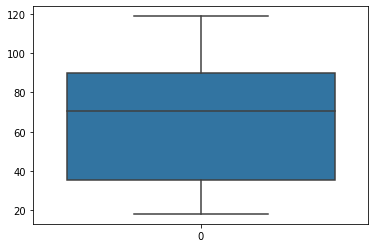

In [ ]:
sns.boxplot(data=contract['MonthlyCharges']) 

In [ ]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [ ]:
contract['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [ ]:
contract[contract['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


По данным видно, что пропуски в общей сумме трат у пользователей, подключившихся в последний месяц выгрузкии. Заменим пропуски на значения в столбце "MonthlyCharges".


In [ ]:
a = list(contract[contract['TotalCharges']==' '].index)
for i in a:
  contract.loc[i, 'TotalCharges'] = contract.loc[i, 'MonthlyCharges'].copy()

In [ ]:
contract.loc[a]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.7
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35


In [ ]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

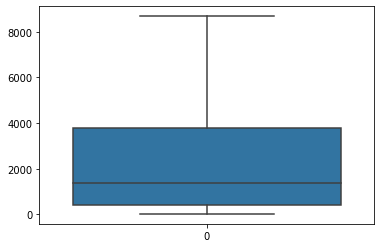

In [ ]:
sns.boxplot(data=contract['TotalCharges']) 

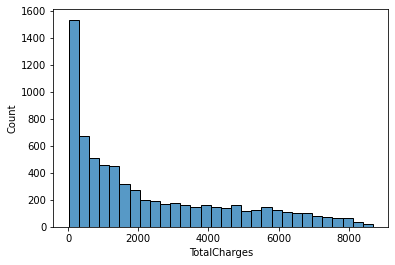

In [ ]:
sns.histplot(data=contract['TotalCharges'], bins=30) 

In [ ]:
contract['TotalCharges'].describe()

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

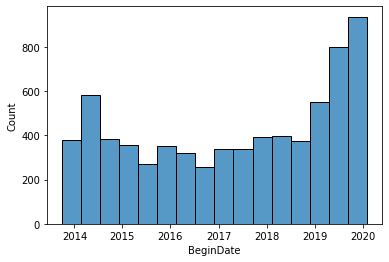

In [ ]:
sns.histplot(data=contract['BeginDate'])

In [ ]:
df = pd.to_datetime(contract[contract['EndDate'] != 'No']['EndDate'],format='%Y.%m.%d %H:%M:%S')
df.value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: EndDate, dtype: int64

По данным видно, что отток клиентов начался в октябре 2019.

Добавим столбец сколько месяцев подключен абонент. Информация актульна на 1 февраля 2020.

In [ ]:
contract['MonthEnd'] = pd.to_datetime(contract['EndDate'].apply(lambda x: '2020-02-01' if x=='No' else x))
contract['UseMonth'] = round((contract['MonthEnd'] - contract['BeginDate'])/np.timedelta64(1, 'M'), 0).astype('int')
contract.drop('MonthEnd', axis=1, inplace=True) 

Преобразуем целевой признак, присвоив ушедшим клиентам 0, всем остальным 1.

In [ ]:
contract['EndDate'] = np.where(contract['EndDate'] == 'No', 0, 1)
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,UseMonth
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,34
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,2
3,7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,45
4,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,2
5,9305-CDSKC,2019-03-01,1,Month-to-month,Yes,Electronic check,99.65,820.50,8
6,1452-KIOVK,2018-04-01,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,22
7,6713-OKOMC,2019-04-01,0,Month-to-month,No,Mailed check,29.75,301.90,10
8,7892-POOKP,2017-07-01,1,Month-to-month,Yes,Electronic check,104.80,3046.05,28
9,6388-TABGU,2014-12-01,0,One year,No,Bank transfer (automatic),56.15,3487.95,62


In [ ]:
contract['EndDate'].value_counts()

0    5174
1    1869
Name: EndDate, dtype: int64

### Выводы 1.0

**На данный момент по просмотренным данным:**
- Целевой признак находится в столбце "EndDate", далее задача будет, скорее всего, в построении модели классификации и данные в столбце можно преобразовать в 0 и 1.
- Изменен тип данных с датой подключения абонента
- Найдены пропуски в значениях с общей суммой у абонентов которые подключились в течении последнего месяца, их можно заполнить значениями из столбца с помесячной оплатой.
- Построены расределения значений по столбцам таблицы "contract"
- По данным видно что отток клиентов начался "2019-10", можно проверить какие изменения произошли у отключившихся абонентов в это время.

## Подготовка признаков

Создадим сводной таблицы со всеми признаками.

In [ ]:
df = contract.merge(personal, how='left', on='customerID')
df = df.merge(internet, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,UseMonth,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,1,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,34,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,2,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,45,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,2,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   int64         
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   UseMonth          7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

Теперь столбец с ID можно удалить. Столбец с датой тоже не понадобится так как добавили столбец с количеством количеством месяцев подключения.

In [ ]:
df = df.drop('customerID', axis=1)
df = df.drop('BeginDate', axis=1)

В сводной таблице появились пропуски. Клиенты могут не подключать связь или интернет, заполним пропуски на значение "No".

In [ ]:
df.fillna(value='No', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7043 non-null   int64  
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   UseMonth          7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


## Анализ моделей

Параметр "random_state" для всех моделей: 101022

Для кодирования категориальных методов применим OrdinalEncoder.

### Проверка на корреляцию признкаков

In [ ]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['EndDate', 'MonthlyCharges', 'TotalCharges', 'UseMonth', 'SeniorCitizen']


,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,UseMonth,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
EndDate,1.00,0.25,0.30,0.45,0.36,0.28,0.47,0.00,0.23,0.23,0.25,0.20,0.26,0.13,0.10,0.25,0.10,0.09,0.06
Type,0.25,1.00,0.11,0.28,0.39,0.51,0.66,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07
PaperlessBilling,0.30,0.11,1.00,0.37,0.47,0.21,0.00,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,0.45,0.28,0.37,1.00,0.40,0.35,0.38,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
MonthlyCharges,0.36,0.39,0.47,0.40,1.00,0.76,0.41,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68
TotalCharges,0.28,0.51,0.21,0.35,0.76,1.00,0.84,0.00,0.15,0.42,0.11,0.51,0.54,0.66,0.67,0.57,0.66,0.67,0.61
UseMonth,0.47,0.66,0.00,0.38,0.41,0.84,1.00,0.00,0.03,0.49,0.21,0.02,0.42,0.47,0.47,0.42,0.36,0.37,0.43
gender,0.00,0.00,0.00,0.00,0.01,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.23,0.09,0.24,0.29,0.30,0.15,0.03,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22
Partner,0.23,0.18,0.01,0.24,0.20,0.42,0.49,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22


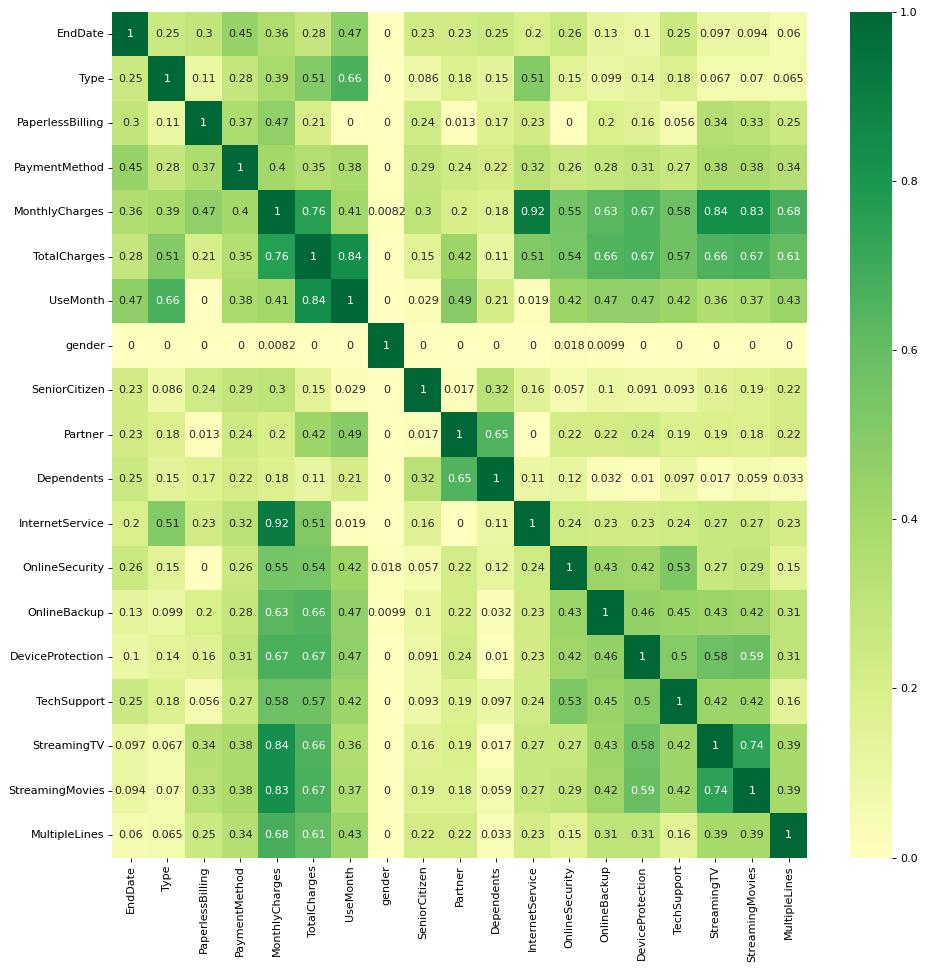

In [ ]:
plt.figure(figsize=(14,14), dpi= 80)
sns.heatmap(phik_overview,  cmap='RdYlGn', center=0, annot=True)

Удалим столбец'TotalCharges'. Он показывает перемноженное значение тарифа на количество месяцев и сильно коррелирует с "MonthlyCharges" и "UseMonth".
А так же удалим столбец "StreamingMovies" он сильно коррелирует с "MonthlyCharges" и "StreamingTV".

In [ ]:
df.drop(['TotalCharges', 'StreamingMovies'], axis=1, inplace=True)

interval columns not set, guessing: ['EndDate', 'MonthlyCharges', 'UseMonth', 'SeniorCitizen']


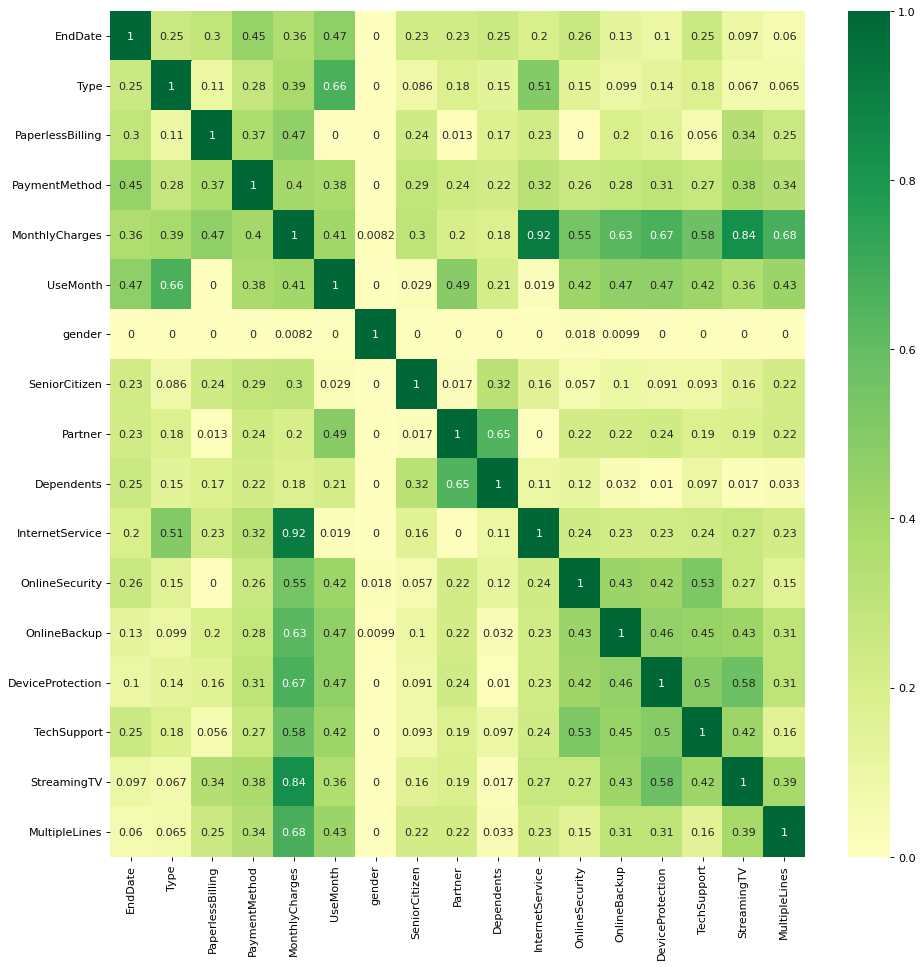

In [ ]:
phik_overview = df.phik_matrix()
phik_overview.round(2)
plt.figure(figsize=(14,14), dpi= 80)
sns.heatmap(phik_overview,  cmap='RdYlGn', center=0, annot=True)

### Подготовка обучающей и тестовой выборок

In [ ]:
random_state = 101022

In [ ]:
X = df.drop('EndDate', axis=1)
y = df['EndDate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=random_state)

### OrdinalEncoder

In [ ]:
cat_futures = [
    'Type', 'PaperlessBilling', 'PaymentMethod',
    'gender', 'SeniorCitizen', 'Partner',
    'Dependents', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'MultipleLines'   
]

In [ ]:
en = OrdinalEncoder()
en.fit(X_train.loc[:, cat_futures])
X_train.loc[:, cat_futures] = en.transform(X_train.loc[:, cat_futures])
X_test.loc[:, cat_futures] = en.transform(X_test.loc[:, cat_futures])

In [ ]:
X_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,UseMonth,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,MultipleLines
317,1.0,0.0,1.0,80.30,38,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
3774,1.0,1.0,2.0,80.85,52,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1817,2.0,0.0,0.0,98.35,72,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4128,0.0,1.0,2.0,39.30,57,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6331,1.0,0.0,2.0,40.30,47,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


### RandomForestClassifier

Перебор гиперпараметров здесь и далее в моделях закомментирован для ускорения работы кода, лучшие гиперпараметры добавлены в аналогичный код для проверки работоспособности моделей и кода.

Так как у нас есть дисбаланс классов примерно 1:3, то для балансировки классов в параметре "class_weight" всех моделей сблансируем классы.

In [ ]:
# rfc = RandomForestClassifier(class_weight={0:1, 1:3},
#                              bootstrap=True,
#                              random_state=random_state)

# rfc_params = {
#     'n_estimators': range(10, 201, 10),
#     'max_depth': range(1,13),
#     'criterion': ['gini', 'entropy'],
#     'max_features': ['sqrt', 'log2']

# }

# gs_rfc = GridSearchCV(rfc,
#                       rfc_params,
#                       verbose=3,
#                       cv=5,
#                       n_jobs=-1,
#                       scoring='roc_auc')


# gs_rfc.fit(X_train, y_train)
# gs_rfc.best_score_
# gs_rfc.best_params_

In [ ]:
rfc = RandomForestClassifier(class_weight={0:1, 1:3},
                             bootstrap=True,
                             random_state=random_state)

rfc_params = {
     'n_estimators': [30],
     'max_depth': [6],
     'criterion': ['entropy'],
     'max_features': ['sqrt']

}

gs_rfc = GridSearchCV(rfc,
                      rfc_params,
                      verbose=3,
                      cv=5,
                      n_jobs=-1,
                      scoring='roc_auc')


gs_rfc.fit(X_train, y_train)
gs_rfc.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.846745599744495

### LGBMClassifier


In [ ]:
# lgbm = LGBMClassifier(random_state=random_state,
#                             class_weight={0:1, 1:3})
# lgbm_params = {
# 'max_depth': [x for x in range(1,6)],
# 'n_estimators': [x for x in range(100,1100, 100)],
# 'learning_rate': [0.5, 0.6, 0.7]
# }


# gs_lgbm = GridSearchCV(lgbm,
#                        lgbm_params,
#                        verbose=3,
#                        cv=5,
#                        n_jobs=-1,
#                        scoring='roc_auc')



# gs_lgbm.fit(X_train, y_train)
# gs_lgbm.best_params_
# # gs_lgbm.best_score_

In [ ]:
lgbm = LGBMClassifier(random_state=random_state,
                            class_weight={0:1, 1:3})
lgbm_params = {
'max_depth': [1],
'n_estimators': [100],
'learning_rate': [0.5]
}


gs_lgbm = GridSearchCV(lgbm,
                       lgbm_params,
                       cv=5,
                       n_jobs=-1,
                       scoring='roc_auc')



gs_lgbm.fit(X_train, y_train)
gs_lgbm.best_score_

0.8470758783452081

### CatBoostClassifier

In [ ]:
# catboost = CatBoostClassifier(loss_function='Logloss',
#                               random_seed=random_state,
#                               class_weight={0:1, 1:3},
#                               silent=True)

# catboost_params = {
# 'depth': [x for x in range(1,5)],
# 'iterations': [x for x in range(100,1100, 100)],
# 'learning_rate': [0.5, 0.6, 0.7],
# 'l2_leaf_reg':[x for x in range(1,7)],
# }



# gs_catboost = GridSearchCV(catboost,
#                            catboost_params, 
#                            verbose=3,
#                            cv=5,
#                            n_jobs=-1,
#                            scoring='roc_auc')


# gs_catboost.fit(X_train, y_train)
# # gs_catboost.best_score_
# gs_catboost.best_params_

In [ ]:
catboost = CatBoostClassifier(loss_function='Logloss',
                              random_seed=random_state,
                              class_weights={0:1, 1:3},
                              silent=True)

catboost_params = {
 'depth': [1],
 'iterations': [100],
 'learning_rate': [0.6],
 'l2_leaf_reg':[4]
}



gs_catboost = GridSearchCV(catboost,
                           catboost_params, 
                           verbose=3,
                           cv=5,
                           n_jobs=-1,
                           scoring='roc_auc')


gs_catboost.fit(X_train, y_train)
gs_catboost.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.8479533380292767

### Сравнение результатов моделей

In [ ]:
results = pd.DataFrame({'Model' : ['Random Forest', 'LGBM', 'CatBoost'], 'ROC-AUC score' : [gs_rfc.best_score_, gs_lgbm.best_score_,gs_catboost.best_score_]})
results

,Model,ROC-AUC score
0,Random Forest,0.846746
1,LGBM,0.847076
2,CatBoost,0.847953


Лучший результат на тренировочной выборке показала модель "CatBoostClassifier".


### Проверка лучшей модели

In [ ]:
prediction = gs_catboost.predict_proba(X_test)[:, 1]

In [ ]:
round(roc_auc_score(y_test, prediction), 2)

0.85

In [ ]:
catboost = CatBoostClassifier(random_seed=random_state, silent=True).fit(X_train,y_train)
feat_imp = catboost.get_feature_importance()
best_futures = pd.DataFrame(feat_imp, index=X.dtypes.index, columns=['Значимость признаков'])\
    .sort_values(by='Значимость признаков', ascending = False).style.bar()
best_futures

,Значимость признаков
UseMonth,20.632481
MonthlyCharges,19.790232
Type,13.756294
PaymentMethod,8.713423
InternetService,6.710040
PaperlessBilling,4.038199
gender,3.636265
Dependents,3.513263
MultipleLines,3.430431
TechSupport,3.295610


## Отчет
### Описание проекта:
- Прогнозирование оттока клиентов из телеком компании

### Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь
- Интернет

### Также доступны такие услуги:
- Подключение: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic)
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity)
- Выделенная линия технической поддержки (TechSupport)
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup)
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies)

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Предобработка данных

В признаках таблицы `contract`:
- `BeginDate`: Изменен тип данных;
- `EndDate`: Значения заменены: 'YYYY-MM-DD' - 0, 'No' - 1;
- `TotalCharges`: Обнаружены пропуски. Заполнены значениями из `MonthlyCharges`. Изменен тип данных;
- Добавлен признак `UseMonth` - количество месяцев подключения.

Все данные собраны в сводную таблицу.

Целевой признак `EndData`. В нём замечен дисбаланс классов в соотношениии 1:3.

Удалены признаки: `custumerID`, `BeginDate`. Появившиеся пропуски заполнены значением 'No'.

### Анализ моделей

Параметр 'random_state' задан для всех моделей: 101022

Проведена проверка на мультиколлениарность признаков. Удалены столбцы: 
- `TotalCharges` - он показывает перемноженное значение тарифа на количество месяцев и сильно коррелирует с `MonthlyCharges` и `UseMonth`; 
- `StreamingMovies` - он сильно коррелирует с `MonthlyCharges` и `StreamingTV`.

Выделен целевой признак (`EndDate`). 

Данные разбиты на обучающую (0.75) и тестовую (0.25) выборки.

Проведено кодирование категориальных признаков (`OrdinalEncoder`).

Задача: получить максимальное значение ROC-AUC.

Для достижения результата выбраны модели: `RandomForestClassifier`, `LGBMClassifier`, `CatBoostClassifier`.

Параметры моделей подбирались на кросс-валидации.

In [ ]:
results

,Model,ROC-AUC score
0,Random Forest,0.846746
1,LGBM,0.847076
2,CatBoost,0.847953


Лучший результат показала модель `CatBoostClassifier`.

Баланс классов задан: `class_weight`={0:1, 1:3}

Параметры лучшей модели на кросс-валидации:
- `depth`: 1,
- `iterations`: 100,
- `learning_rate`: 0.6,
- `l2_leaf_reg`: 4.

**ROC-AUC на тестовой выборке для CatBoostClassifier равен 0.85**

Значимость признаков для модели `CatBoostClassifier`.



In [ ]:
best_futures

,Значимость признаков
UseMonth,20.632481
MonthlyCharges,19.790232
Type,13.756294
PaymentMethod,8.713423
InternetService,6.710040
PaperlessBilling,4.038199
gender,3.636265
Dependents,3.513263
MultipleLines,3.430431
TechSupport,3.295610
